In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tqdm.notebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
DATA_DIR = r"F:\Project\GPU\CV\brain2_filtered"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 32        # safe + fast
EPOCHS = 5             # finishes in ~15–20 min
LR = 1e-4
NUM_CLASSES = 4


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [5]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
model = models.convnext_tiny(pretrained=True)

model.classifier[2] = nn.Linear(
    model.classifier[2].in_features,
    NUM_CLASSES
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)


f:\Project\GPU\gpuenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Project\GPU\gpuenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\adity/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [01:42<00:00, 1.12MB/s] 


In [7]:
train_acc_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # -------- Training --------
    model.train()
    correct, total = 0, 0
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(
            loss=running_loss/(total/BATCH_SIZE),
            acc=correct/total
        )

    train_acc = correct / total
    train_acc_history.append(train_acc)

    # -------- Validation --------
    model.eval()
    correct, total = 0, 0

    val_bar = tqdm(test_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_bar.set_postfix(acc=correct/total)

    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"✔ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Epoch 1/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

✔ Train Acc: 0.9055 | Val Acc: 0.9664

Epoch 2/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

✔ Train Acc: 0.9778 | Val Acc: 0.9908

Epoch 3/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

✔ Train Acc: 0.9914 | Val Acc: 0.9847

Epoch 4/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

✔ Train Acc: 0.9900 | Val Acc: 0.9878

Epoch 5/5


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

✔ Train Acc: 0.9940 | Val Acc: 0.9947


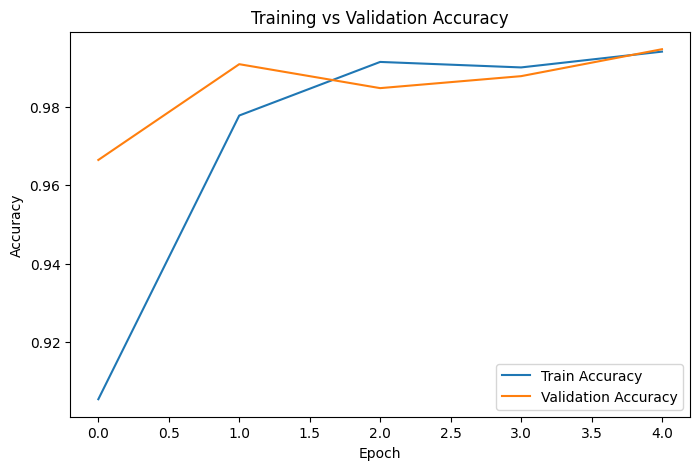

In [8]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


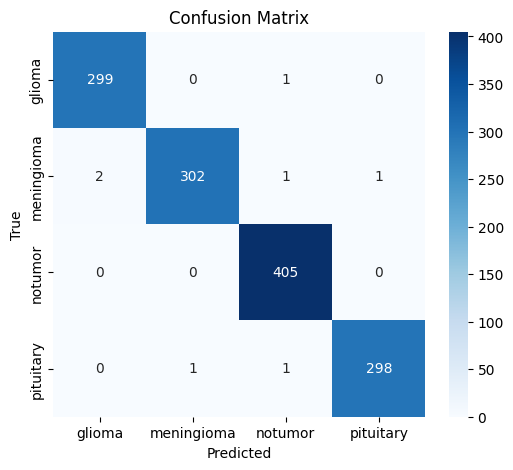

In [9]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
torch.save(model.state_dict(), "convnext_tiny_brain_tumor.pth")
print("✅ Model saved successfully")


✅ Model saved successfully


In [12]:
import random

def plot_predictions(model, dataloader, class_names, device, num_images=8):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.show()
                    return

                img = images[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + \
                      torch.tensor([0.485, 0.456, 0.406])
                img = img.clamp(0, 1)

                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                color = "green" if true_label == pred_label else "red"

                plt.subplot(2, num_images // 2, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                          color=color, fontsize=10)
                plt.axis("off")

                images_shown += 1

    plt.show()


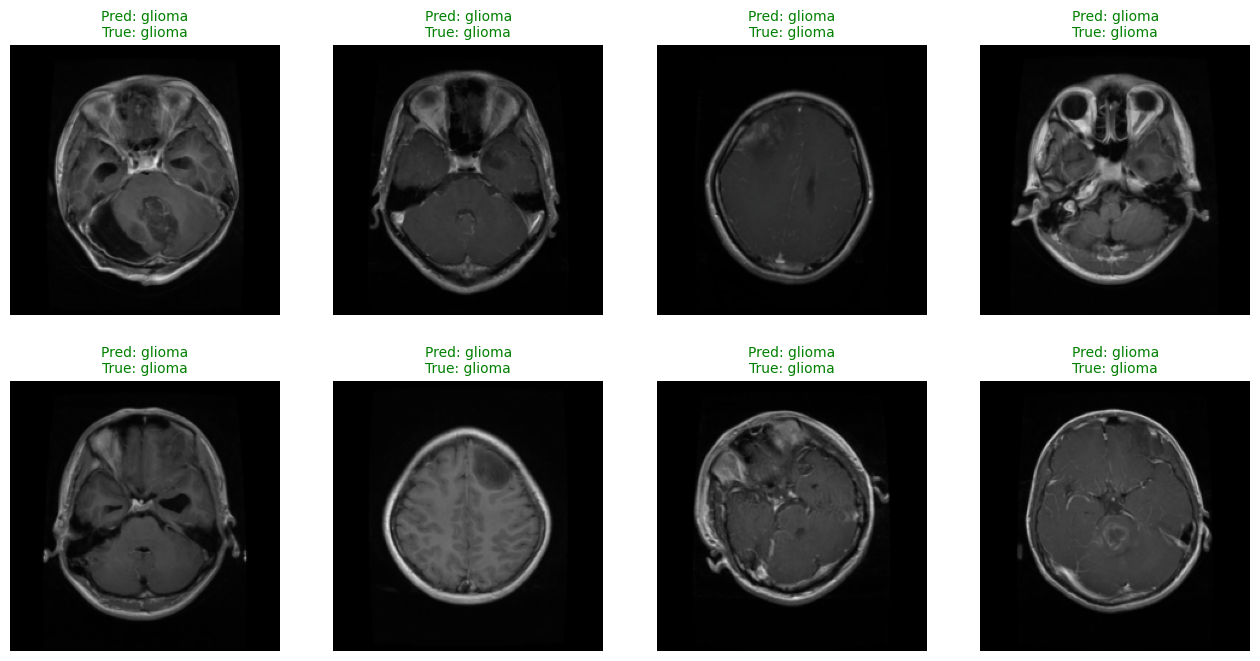

In [13]:
plot_predictions(
    model=model,
    dataloader=test_loader,
    class_names=class_names,
    device=device,
    num_images=8
)


In [14]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# Ensure model is in eval mode
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# ---- Overall Metrics ----
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("📊 Overall Metrics")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# ---- Per-Class Metrics ----
print("\n📋 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


📊 Overall Metrics
Accuracy : 0.9947
Precision: 0.9947
Recall   : 0.9947
F1-score : 0.9947

📋 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       300
  meningioma       1.00      0.99      0.99       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

